✅ Kích thước dữ liệu: (1693, 19)
📅 Thời gian: 2020-10-03 00:00:00 → 2025-08-17 00:00:00
🧩 Biến đầu vào sử dụng: ['Annulus pressure_avg', 'Flow pressure_avg', 'Buffer pressure_avg', 'T_avg', 'Gas injection rate', 'Choke', 'Downtime']
🧠 Train size: (1354, 7), Test size: (339, 7)


/tmp/ipython-input-725009915.py:48: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = X.fillna(method="ffill").fillna(method="bfill")
/tmp/ipython-input-725009915.py:49: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  y = y.fillna(method="ffill").fillna(method="bfill")


🎯 Mô hình đã huấn luyện xong!

📈 Kết quả đánh giá mô hình:
MAE  = 6.398
MSE  = 81.261
RMSE = 9.014
R²   = 0.531

🔍 Tầm quan trọng của các đặc trưng:
                Feature  Importance
4    Gas injection rate    0.206097
0  Annulus pressure_avg    0.205678
2   Buffer pressure_avg    0.187137
3                 T_avg    0.179220
1     Flow pressure_avg    0.101627
5                 Choke    0.097381
6              Downtime    0.022861


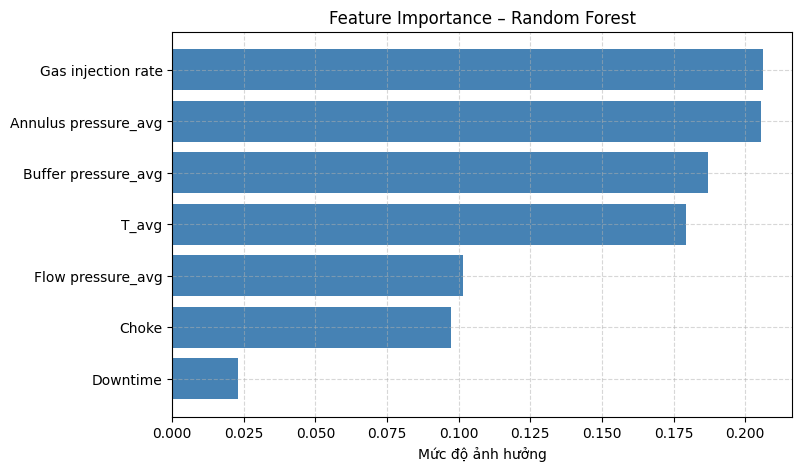

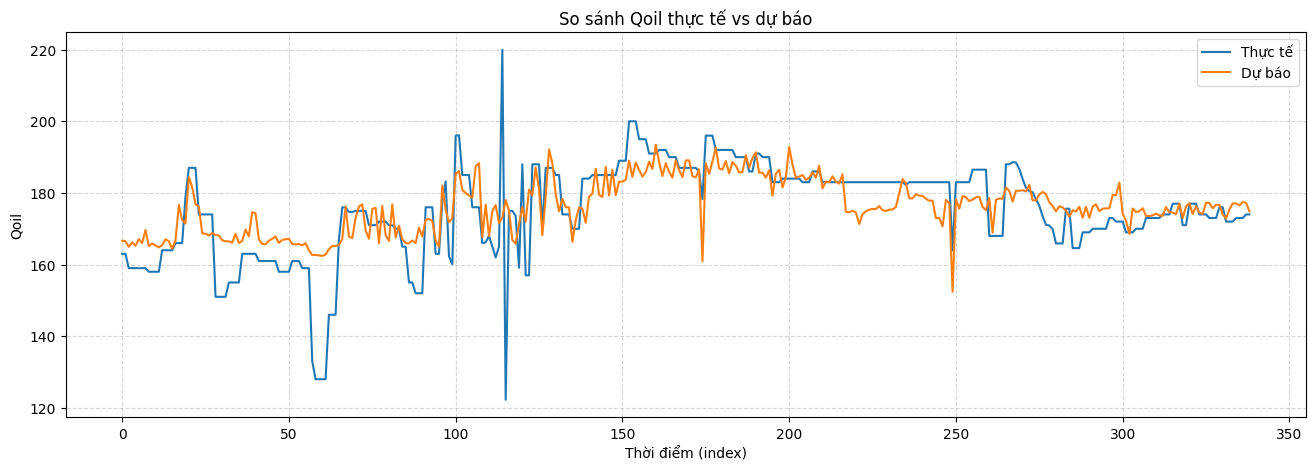

In [11]:
import pandas as pd
import numpy as np
from scipy.signal import savgol_filter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

file_path = "/content/drive/MyDrive/Dữ liệu/BK_20_Test_3_clean.csv"
df = pd.read_csv(file_path)

# Chuyển cột Date về dạng thời gian
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

print("✅ Kích thước dữ liệu:", df.shape)
print("📅 Thời gian:", df["Date"].min(), "→", df["Date"].max())

pairs = [
    ('Annulus pressure', 'Annulus pressure min', 'Annulus pressure max'),
    ('Buffer pressure', 'Buffer pressure min', 'Buffer pressure max'),
    ('Flow pressure', 'Flow pressure min', 'Flow pressure max'),
    ('T', 'T min', 'T max')
]
for name, col_min, col_max in pairs:
    if col_min in df.columns and col_max in df.columns:
        df[f'{name}_avg'] = (df[col_min] + df[col_max]) / 2

features = [
    'Annulus pressure_avg','Flow pressure_avg', 'Buffer pressure_avg',
    'T_avg',
    'Gas injection rate', 'Choke', 'Downtime'
]

# Kiểm tra cột nào tồn tại trong file thực tế
features = [f for f in features if f in df.columns]
print("🧩 Biến đầu vào sử dụng:", features)

target = "Qliq"


X = df[features]
y = df[target]


# Điền giá trị thiếu bằng phương pháp nội suy/forward-fill
X = X.fillna(method="ffill").fillna(method="bfill")
y = y.fillna(method="ffill").fillna(method="bfill")


split_index = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

print(f"🧠 Train size: {X_train.shape}, Test size: {X_test.shape}")

# window_size_y = 2
# y_train_original = y_train.copy() # tạo bản sao giá trị y_tran
# y_train_smooth = y_train.rolling(window=window_size_y, min_periods=1).mean()
# y_train = y_train_smooth


pipe = Pipeline([
    ("scaler", StandardScaler()),  # Chuẩn hóa dữ liệu (Z-score)
    ("model", RandomForestRegressor(
        n_estimators=1000,       # Số lượng cây
        max_depth=None,         # Độ sâu tự động
        max_features = 1,
        random_state=42,        # Cố định seed cho tái lập
        n_jobs=-1               # Dùng toàn bộ CPU core
    ))
])


pipe.fit(X_train, y_train)
print("🎯 Mô hình đã huấn luyện xong!")


y_pred = pipe.predict(X_test)


mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("\n📈 Kết quả đánh giá mô hình:")
print(f"MAE  = {mae:.3f}")
print(f"MSE  = {mse:.3f}")
print(f"RMSE = {rmse:.3f}")
print(f"R²   = {r2:.3f}")


importances = pipe.named_steps["model"].feature_importances_
feat_imp = pd.DataFrame({
    "Feature": features,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

print("\n🔍 Tầm quan trọng của các đặc trưng:")
print(feat_imp)


plt.figure(figsize=(8, 5))
plt.barh(feat_imp["Feature"], feat_imp["Importance"], color="steelblue")
plt.xlabel("Mức độ ảnh hưởng")
plt.title("Feature Importance – Random Forest")
plt.gca().invert_yaxis()
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


plt.figure(figsize=(16, 5))
plt.plot(y_test.values, label="Thực tế", marker="")
plt.plot(y_pred, label="Dự báo", marker="")
plt.title("So sánh Qoil thực tế vs dự báo")
plt.xlabel("Thời điểm (index)")
plt.ylabel("Qoil")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()